# Solution Planning (IoT)

## Input

**Business Challange**
    
    1. Build a model to order customers most likely to buy vehicle insurance.
    
**Business Questions**
    
    1. Main Insights on the most relevant attributes of customers interested in purchasing auto insurance.

    2. What percentage of customers interested in purchasing auto insurance will the sales team be able to contact by making 20,000 calls?

    3. If the sales team capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?

    4. How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?
    
**Data base**

    Information about customers who participate in a survey by answering whether they would be interested in car insurance.

## Output

    1. Customers interested in car insurance for the sales team to call.

    Customer Id | interest % 
        01      |     0.99
        02      |     0.97
        03      |     0.90
        
    2. Report with business Questions

## Tasks

      1. Model to rank customers by higher interest in car insurance
  
      2. Exploratory Data Analysis Report about the top feature importance
  
      3. The number of customers interested in car insurance

# Development Enviroment

## Package Installations

In [2]:
#!pip install psycopg2-binary
#!pip install psycopg2
!pip install sklearn

## Imports

In [2]:
# Data Processing
import pandas as pd
#import pandas.io.sql as psql
import psycopg2 as pg
import numpy as np
import pickle

# Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scikitplot as skplt
from scipy.stats import chi2_contingency
from IPython.display import Image

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# API
from flask import Flask, request, Response
import requests
import json

## Settings

In [43]:
matplotlib.rcParams['figure.figsize'] = [14, 10]

## Functions

### Data Collect

In [26]:
def pg_query(query_schema):
    '''
    --> Queries the database
    
    :param query_schema: Specific schema to be query
    '''
    conn = pg.connect(database=database, user=username, password=password, host=host, port=port)
    cursor = conn.cursor()
    cursor.execute(query_schema)
    record = cursor.fetchall()
    cursor.close()
    conn.close()
    print(record)

### Data Visualization

In [31]:
def graph_info(title: str, x_lable= None):
    '''
    --> Show the title of a graph
    
    :param title: Title to display
    :param x_lable: X lable description
    '''
    plt.title(title, loc='left', fontsize=18)
    plt.xlabel(x_lable)
    plt.show()

In [27]:
def box_hist_plot(variable = str):
    '''
    --> Bivariate analysis of variables and response target
    
    :param variable: Variable to be compare with response
    '''
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df4, x='response', y=variable )
    plt.title(f'{variable} X Response', loc='left', fontsize=18)

    plt.subplot(1, 2, 2)
    sns.histplot(df4, x=variable, hue='response')
    plt.show()

In [26]:
def frequency_table(data: pd.DataFrame):
    '''
    --> Show a bivariate table of proportion about independent and target variables
    
    :data: DataFrame to visualize proportion table
    '''
    df = pd.DataFrame(round(data.value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
    df['Count'] = data.value_counts().values
    display(df)

In [61]:
def cramer_v(x, y):
    '''
    --> Categorical variable correlation calc
    
    :param x: column 1
    :param y: column 2
    
    return cramer v correlation
    '''
    #cm: crosstab matrix apply to categoricals variables  
    #n: sum of crosstab matrix 
    #r: rows
    #k: columns
    cm = np.array(pd.crosstab(x, y))
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency(cm)[0]
    chi2_corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))

    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    return np.sqrt((chi2_corr / n) / (min(kcorr - 1, rcorr - 1)))

### Metrics

In [51]:
def precision_at_k( data, k=2000, model_name=str):
    '''
    --> Calculate the model precision at the k position in ranking
    
    :param dataframe data: The data with response and probabilities calculated
    :param int k: The k ranking position to return the precision
    :param str model_name: The name of Machine Learning model that calculate the probabilites
    
    print The precison at k ranking position
    '''
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    print(f"Model: {model_name} \nRanking Position: {k} \nPrecison: {round(data.loc[k, 'precision_at_k'], 2)}") 

In [52]:
def recall_at_k( data, k=2000, model_name=str):
    '''
    --> Calculate the model recall at the k ranking position
    
    :param dataframe data: The data with response and probabilities calculated
    :param int k: The k ranking position to return the recall 
    :param str model_name: The name of Machine Learning model that calculate the probabilites
    
    return The recall at k ranking position
    '''
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    print(f"Model: {model_name} \nRanking Position: {k} \nRecall: {round(data.loc[k, 'recall_at_k'], 2)}") 

# Data Collect

## Data base connection

In [8]:
# Credentials
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = '5432'
database = 'comunidadedsdb'
username = 'member'
password = 'cdspa'

### Schema Query

In [9]:
# connection
conn = pg.connect(database=database, user=username, password=password, host=host, port=port)

OperationalError: could not translate host name "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com" to address: Temporary failure in name resolution


In [25]:
# cursor
cursor = conn.cursor()

query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

cursor.execute(query_schema)
record = cursor.fetchall()
print(record)
cursor.close()
conn.close()

[('pg_toast',), ('pg_temp_1',), ('pg_toast_temp_1',), ('pg_catalog',), ('information_schema',), ('public',), ('pa004',), ('pg_temp_4',), ('pg_toast_temp_4',), ('pa005',), ('pg_temp_9',), ('pg_toast_temp_9',)]


### Table Query

In [27]:
query_schema = """
    SELECT tablename
    FROM pg_tables
    WHERE schemaname='pa004'
"""
pg_query(query_schema)

[('users',), ('vehicle',), ('insurance',)]


### Collect data using Psycopg2

In [59]:
conn = pg.connect(database=database, user=username, password=password, host=host, port=port)
query_schema = '''
SELECT *
FROM pa004.users u LEFT JOIN pa004.vehicle v on (u.id = v.id)
                  LEFT JOIN pa004.insurance i on (u.id = i.id)
'''
df_raw = psql.read_sql(query_schema, conn)

In [60]:
conn.close()

### Collect data using Pandas

In [11]:
conn = pg.connect(database=database, user=username, password=password, host=host, port=port)
query_schema = '''
SELECT *
FROM pa004.users u LEFT JOIN pa004.vehicle v on (u.id = v.id)
                  LEFT JOIN pa004.insurance i on (u.id = i.id)
'''
df_raw = pd.read_sql(query_schema, conn)
conn.close()

In [13]:
df_raw.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel', 'id',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'id',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [15]:
df_raw = df_raw.iloc[:, [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13]]

In [16]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## Process File

In [17]:
df_raw.to_csv('../data/raw/df_raw.csv', index=False)

## Data Fields

In [47]:
data_raw_fields = {'id': 'Unique ID for the customer',
                'gender': 'Gender of the customer',
                'age': 'Age of the customer',
                'driving_license': '0 : Customer does not have DL, 1 : Customer already has DL',
                'region_code': 'Unique code for the region of the customer',
                'previously_insured': '1 : Customer already has Vehicle Insurance, 0 : Customer doesn"t have Vehicle Insurance',
                'vehicle_age': 'Age of the Vehicle',
                'vehicle_damage': '1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn"t get his/her vehicle damaged in the past.',
                'annual_premium': 'The amount customer needs to pay as premium in the year',
                'policy_sales_hannel': 'Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.',
                'vintage': 'Number of Days, Customer has been associated with the company',
                'response': '1 : Customer is interested, 0 : Customer is not interested'}

data_raw_fields

{'id': 'Unique ID for the customer',
 'gender': 'Gender of the customer',
 'age': 'Age of the customer',
 'driving_license': '0 : Customer does not have DL, 1 : Customer already has DL',
 'region_code': 'Unique code for the region of the customer',
 'previously_insured': '1 : Customer already has Vehicle Insurance, 0 : Customer doesn"t have Vehicle Insurance',
 'vehicle_age': 'Age of the Vehicle',
 'vehicle_damage': '1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn"t get his/her vehicle damaged in the past.',
 'annual_premium': 'The amount customer needs to pay as premium in the year',
 'policy_sales_hannel': 'Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.',
 'vintage': 'Number of Days, Customer has been associated with the company',
 'response': '1 : Customer is interested, 0 : Customer is not interested'}

# Data Description

In [18]:
df1 = pd.read_csv('../data/raw/df_raw.csv')

In [19]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## Dimensions

In [20]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 381109
Number of columns: 12


## Data types

In [21]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## Check NaN

In [22]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## Descriptive Statistics

- **Location Estimate**
        
        Mean
        Median
        Min
        Max

- **Dispersion Estimate**
    
        Standard Deviation
        Range

- **Skewness**
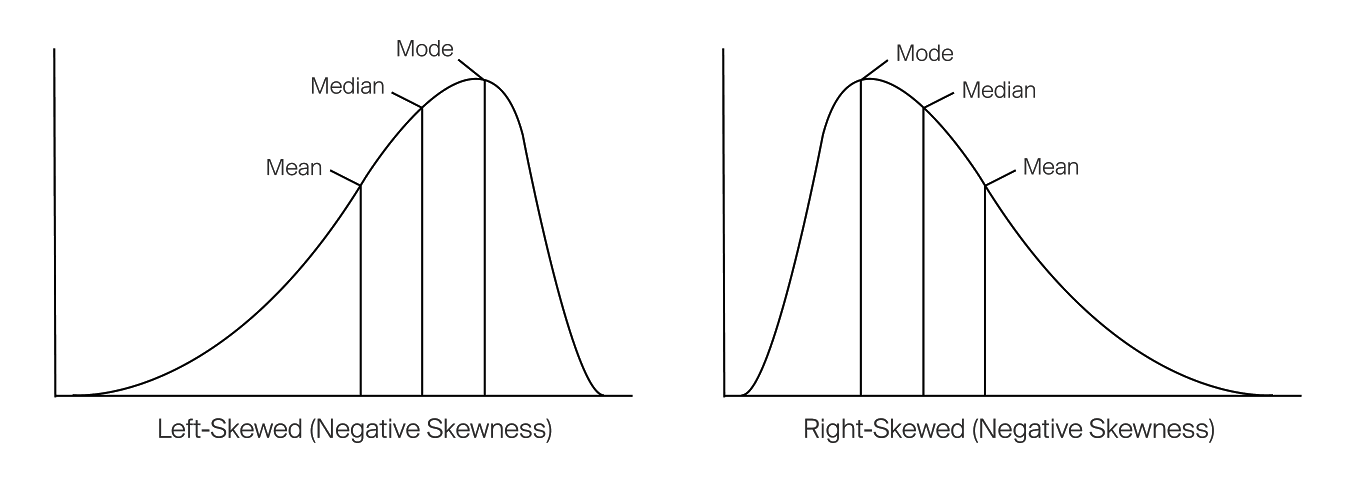
- **Kurtosis**
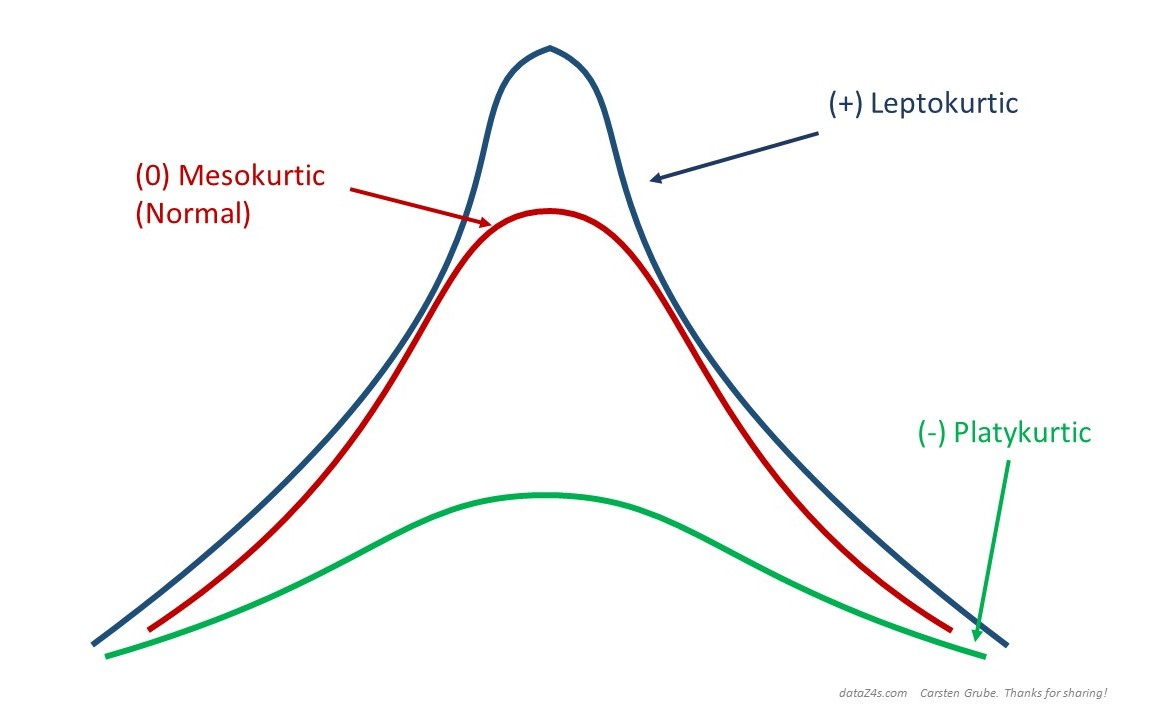

In [23]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### Numerical Attributes

In [24]:
aux = num_attributes.describe().T
aux['range'] = aux['max'] - aux['min']
aux['skewness'] = num_attributes.apply(lambda x: x.skew())
aux['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())
aux = aux.rename(columns={'50%': 'median'})
aux[['min', 'max', 'range', 'median', 'mean', 'std', 'skewness', 'kurtosis']]

,min,max,range,median,mean,std,skewness,kurtosis
id,1.0,381109.0,381108.0,190555.0,190555.000000,110016.836208,-8.071174e-18,-1.200000
age,20.0,85.0,65.0,36.0,38.822584,15.511611,6.725390e-01,-0.565655
region_code,0.0,52.0,52.0,28.0,26.388807,13.229888,-1.152664e-01,-0.867857
policy_sales_channel,1.0,163.0,162.0,133.0,112.034295,54.203995,-9.000081e-01,-0.970810
driving_license,0.0,1.0,1.0,1.0,0.997869,0.046110,-2.159518e+01,464.354302
previously_insured,0.0,1.0,1.0,0.0,0.458210,0.498251,1.677471e-01,-1.971871
annual_premium,2630.0,540165.0,537535.0,31669.0,30564.389581,17213.155057,1.766087e+00,34.004569
vintage,10.0,299.0,289.0,154.0,154.347397,83.671304,3.029517e-03,-1.200688
response,0.0,1.0,1.0,0.0,0.122563,0.327936,2.301906e+00,3.298788


Notes:

   **Age**: There are more young customers
    
   **Policy sales channel**: There are many channels
    
   **Driving licnece**: Most customers have a driver's license 
    
   **Annual premium**: Concentrated on high values
    
   **Vintage**: Indicates that customers have about 5 months of relationship with the company

### Categorical Attributes

In [29]:
frequency_table(cat_attributes)

,gender,vehicle_age,vehicle_damage,%,Count
0,Male,1-2 Year,Yes,21.0,79533
1,Female,< 1 Year,No,17.0,66047
2,Male,< 1 Year,No,13.0,50543
3,Female,1-2 Year,Yes,13.0,48692
4,Male,1-2 Year,No,11.0,42791
5,Female,1-2 Year,No,8.0,29300
6,Female,< 1 Year,Yes,7.0,25274
7,Male,< 1 Year,Yes,6.0,22922
8,Male,> 2 Years,Yes,3.0,10293
9,Female,> 2 Years,Yes,1.0,5699


# Feature Engineering

## Mind Map Hyphotesis

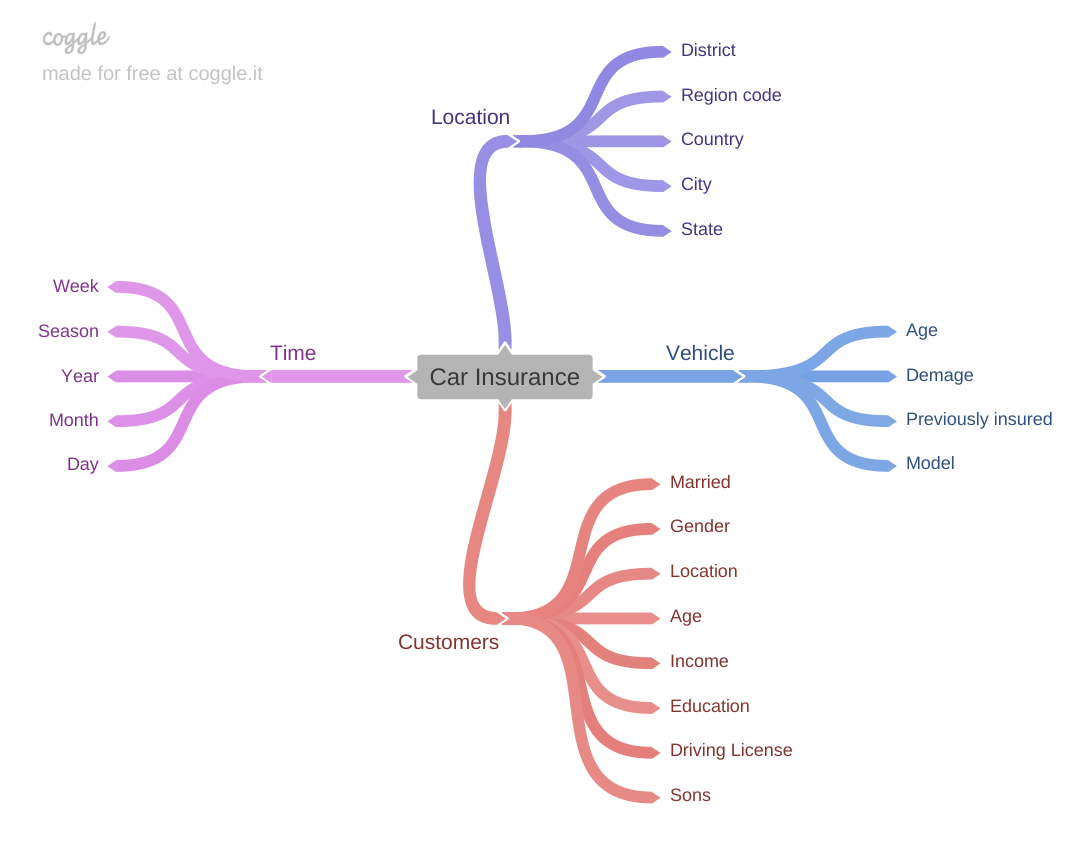

In [26]:
Image('/home/marcos/Documents/pa004_health_insurance_cross_sell/cross_sell/reports/figures/car_insurance_mind_map.png')

### Vehicle Hyphotesis

    H1. New cars are more insured
    H2. Damaged cars are more insured

### Customers Hyphotesis

    H1. Women are more interested in insurance than men
    H2. Older people are more interested in auto insurance

### Time Hyphotesis

### Location Hyphotesis

    H1. The region has influences on the interest in car insurance

### Hyphotesis List

    H1. New cars are more insured
    H2. Damaged cars are more insured
    H3. Women are more interested in insurance than men
    H4. Older people are more interested in auto insurance
    H5. The region has influences on the interest in car insurance

## Feature Creation/ Manipulation

In [30]:
df2 = pd.read_csv('../data/raw/df_raw.csv')
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


In [31]:
'''
vehicle_age 
< 1 Year = bellow_1_year 
1-2 Year = between_1_2_year
> 2 Year = over_2_years
'''
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'below_1_year' if x == '< 1 Year' else 
                                  'between_1_2_year' if x == '1-2 Year' else 
                                  'over_2_years')

'''
vehicle_damage
Yes = 1
No = 0
'''
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

## Otput Data

In [32]:
df2.to_csv('../data/processed/df_feature_engineering.csv', index=False)

# Data Filtering

# EDA

In [3]:
df4 = pd.read_csv('../data/processed/df_feature_engineering.csv')
num_attributes = df4.select_dtypes(['int64', 'float64'])
cat_attributes = df4.select_dtypes(['object'])

## Univariate Analysis

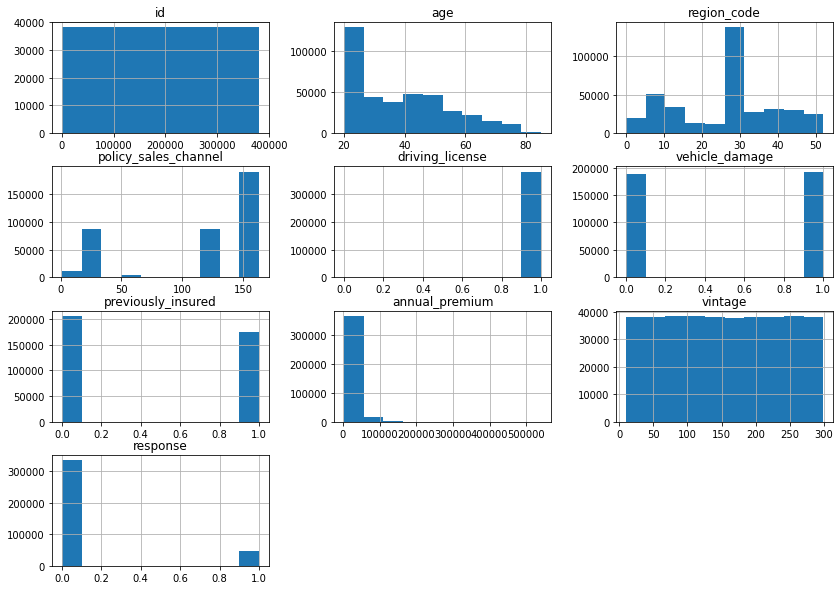

In [17]:
num_attributes.hist()
plt.show()

<font size=5>Categoricals Variables</font>

<AxesSubplot:xlabel='vehicle_age', ylabel='Count'>

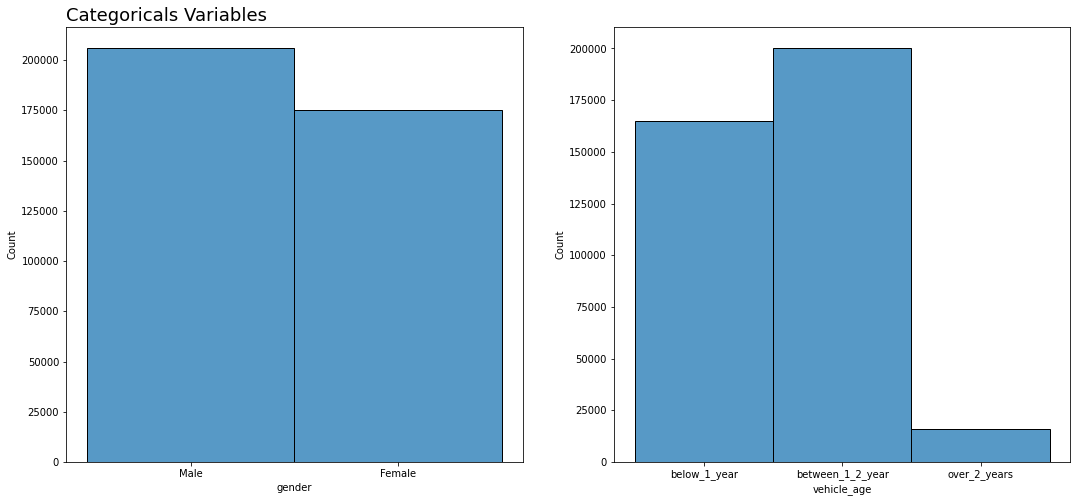

In [37]:
plt.figure(figsize=[18, 8])
plt.subplot(1, 2, 1)
sns.histplot(data=cat_attributes, x=cat_attributes.columns[0])
plt.title('Categoricals Variables', loc='left', fontsize=18)

plt.subplot(1, 2, 2)
sns.histplot(data=cat_attributes, x=cat_attributes.columns[1])

<font size=4.5>The vehicle age have minus than 2 years in the most of the case</font>

## Bivariate Analysis

### H1. New cars are more insured

**Result:** True

**Method:** Count frequency the alredy insured cars by the age

**Conclusion:** Cars less than 1 year old represent 63% of those who already have insurance

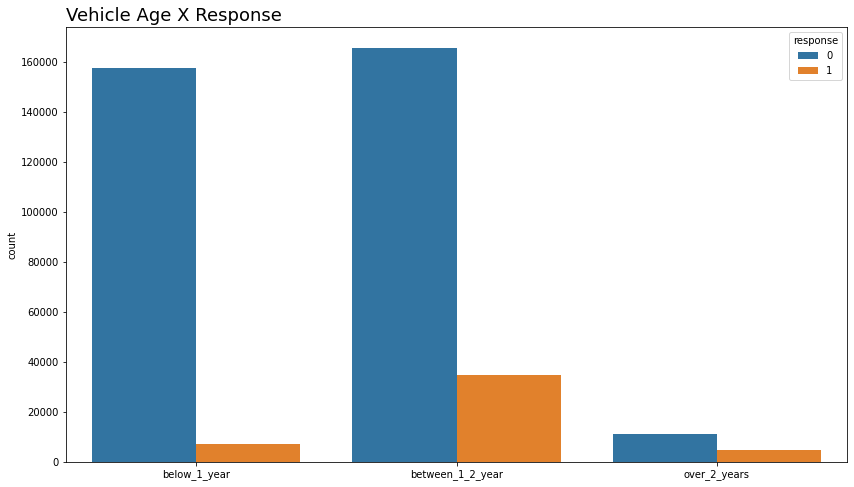

In [39]:
sns.countplot(data=df4, x='vehicle_age', hue='response')
graph_info('Vehicle Age X Response')

In [40]:
frequency_table(df4[['vehicle_age', 'response']])

,vehicle_age,response,%,Count
0,between_1_2_year,0,43.0,165510
1,below_1_year,0,41.0,157584
2,between_1_2_year,1,9.0,34806
3,over_2_years,0,3.0,11305
4,below_1_year,1,2.0,7202
5,over_2_years,1,1.0,4702


In [33]:
print('Previosly Insured and Vehicle Age')
round(df4[df4['previously_insured'] == 1]['vehicle_age'].value_counts(normalize=True) * 100)

Previosly Insured and Vehicle Age


below_1_year        63.0
between_1_2_year    37.0
over_2_years         0.0
Name: vehicle_age, dtype: float64

### H2. Damaged cars are more insured

**Result:** False

**Method:** Count frequency the alredy insured cars by the demage occurency

**Conclusion:** Customers who had their car damaged are more interested in insurance, but customers who already have insurance only 6% of them have been damaged.

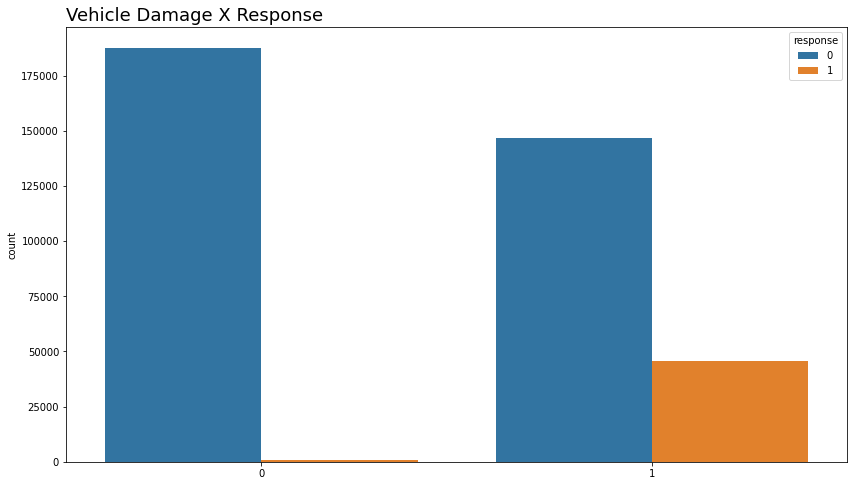

In [47]:
sns.countplot(data=df4, x='vehicle_damage', hue='response')
graph_info('Vehicle Damage X Response')

In [50]:
frequency_table(df4[df4['vehicle_damage'] == 1][['vehicle_damage', 'response']])

,vehicle_damage,response,%,Count
0,1,0,76.0,146685
1,1,1,24.0,45728


In [40]:
print('Already Insured X Vehicle Damage')
round(df4[df4['previously_insured'] == 1]['vehicle_damage'].value_counts(normalize=True) * 100)

Already Insured X Vehicle Damage


0    94.0
1     6.0
Name: vehicle_damage, dtype: float64

<font size=4.5>Approximately 1/4 of customers who have had damage to vehicles are interested in car insurance</font>

### H3. Women are more interested in insurance than men

**Result:** False

**Method:** Count frequency

**Conclusion:** Of the group that is interested in insurance, men represent 61%.

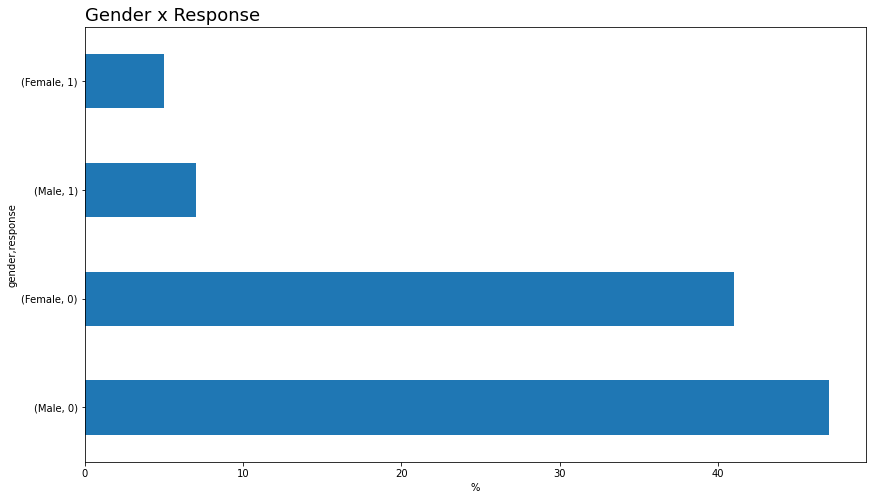

In [38]:
round(df4[['gender', 'response']].value_counts(normalize=True) * 100).plot(kind='barh')
graph_info('Gender x Response', x_lable='%')

In [39]:
print('Already Insured X Gender')
round(df4[df4['previously_insured'] == 1]['gender'].value_counts(normalize=True) * 100)

Already Insured X Gender


Female    50.0
Male      50.0
Name: gender, dtype: float64

In [38]:
print('Insurance Interest X Gender')
round(df4[df4['response'] == 1]['gender'].value_counts(normalize=True) * 100)

Insurance Interest X Gender


Male      61.0
Female    39.0
Name: gender, dtype: float64

In [42]:
print('Gender Proportion')
df4['gender'].value_counts(normalize=True)

Gender Proportion


Male      0.540761
Female    0.459239
Name: gender, dtype: float64

### H4. Older people are more interested in auto insurance

**Result:** True

**Method:** Median

**Conclusion:** The people in the stakeholder group are older.

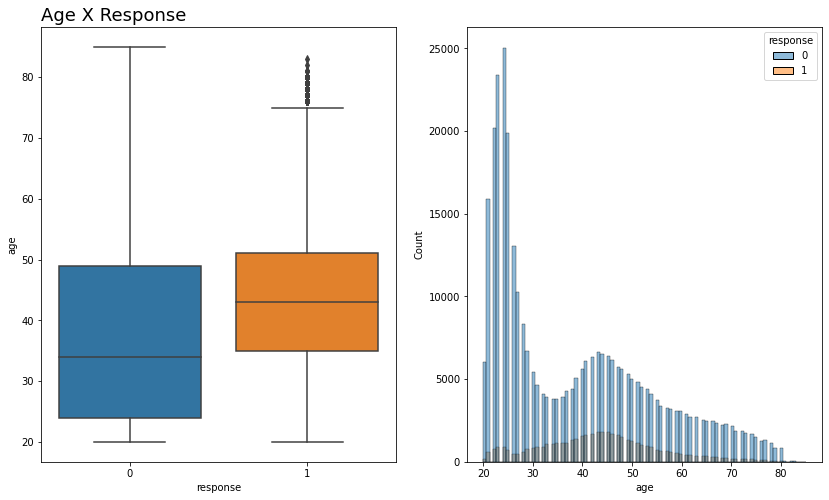

In [42]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
sns.boxplot(data=df4, x='response', y='age' )
plt.title('Age X Response', loc='left', fontsize=18)

plt.subplot(1, 2, 2)
sns.histplot(df4, x='age', hue='response')
plt.show()

In [34]:
print('Age of positive response customers')
df4[df4['response'] == 1]['age'].describe()

Age of positive response customers


count    46710.000000
mean        43.435560
std         12.168924
min         20.000000
25%         35.000000
50%         43.000000
75%         51.000000
max         83.000000
Name: age, dtype: float64

In [35]:
print('Age of negative response customers')
df4[df4['response'] == 0]['age'].describe()

Age of negative response customers


count    334399.000000
mean         38.178227
std          15.816052
min          20.000000
25%          24.000000
50%          34.000000
75%          49.000000
max          85.000000
Name: age, dtype: float64

In [52]:
# Create a series with bined age
age_10 = pd.Series(pd.cut(df4['age'], bins=10), name='age_10')
# Aux variable with columns to look
aux = df4[['age', 'response']]
# Age bined age to aux
aux = pd.concat([aux, age_10], axis=1)
# Crosstab analysis
round(pd.crosstab(aux['age_10'], aux['response'], normalize='columns') * 100)

response,0,1
age_10,,
"(19.935, 26.5]",37.0,10.0
"(26.5, 33.0]",13.0,12.0
"(33.0, 39.5]",8.0,15.0
"(39.5, 46.0]",13.0,26.0
"(46.0, 52.5]",9.0,17.0
"(52.5, 59.0]",8.0,11.0
"(59.0, 65.5]",5.0,5.0
"(65.5, 72.0]",5.0,3.0
"(72.0, 78.5]",3.0,1.0


In [55]:
print(f'Customers between 33 and 52 years old represet {15 + 26 + 17}% of positive response group')

Customers between 33 and 52 years old represet 58% of positive response group


### H5. The region has influences on the interest in car insurance

**Result:** False

**Method:** Standard Deviation

**Conclusion:** The standard deviation of the response of the two groups is very low, indicating that the region code has no significant influence.

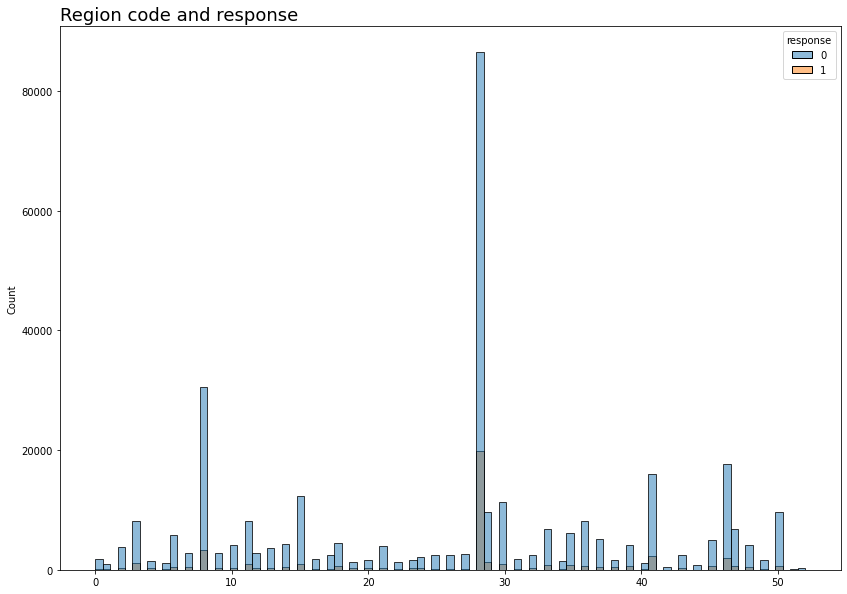

In [32]:
sns.histplot(x='region_code', data=df4, hue='response')
graph_info('Region code and response')

In [30]:
region_response = round(pd.crosstab(df4['region_code'], df4['response'], normalize='index') * 100)
region_response

response,0,1
region_code,,
0.0,91.0,9.0
1.0,89.0,11.0
2.0,93.0,7.0
3.0,87.0,13.0
4.0,84.0,16.0
5.0,88.0,12.0
6.0,93.0,7.0
7.0,87.0,13.0
8.0,90.0,10.0


In [26]:
region_response[0].describe()

count    53.000000
mean     89.981132
std       3.405259
min      81.000000
25%      88.000000
50%      90.000000
75%      93.000000
max      96.000000
Name: 0, dtype: float64

In [27]:
region_response[1].describe()

count    53.000000
mean     10.018868
std       3.405259
min       4.000000
25%       7.000000
50%      10.000000
75%      12.000000
max      19.000000
Name: 1, dtype: float64

### Categoricals Variables

<font size=4.5>The gender don't seems to have an influence of response variable</font>

In [41]:
frequency_table(df4[df4['vehicle_age'] == 'over_2_years'][['vehicle_age', 'response']])

,vehicle_age,response,%,Count
0,over_2_years,0,71.0,11305
1,over_2_years,1,29.0,4702


<font size=4.5>29% of clients that vehicle age is greather than 2 years have intereset in car insurance</font>

### Numericals Variables

<font size=4.5>The vehicle insurance increase between 40 and 50 customers years old.</font>

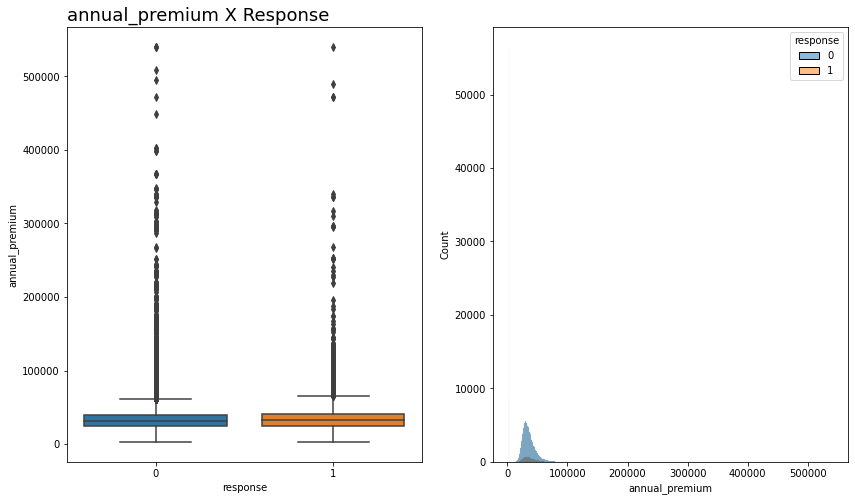

In [43]:
box_hist_plot('annual_premium')

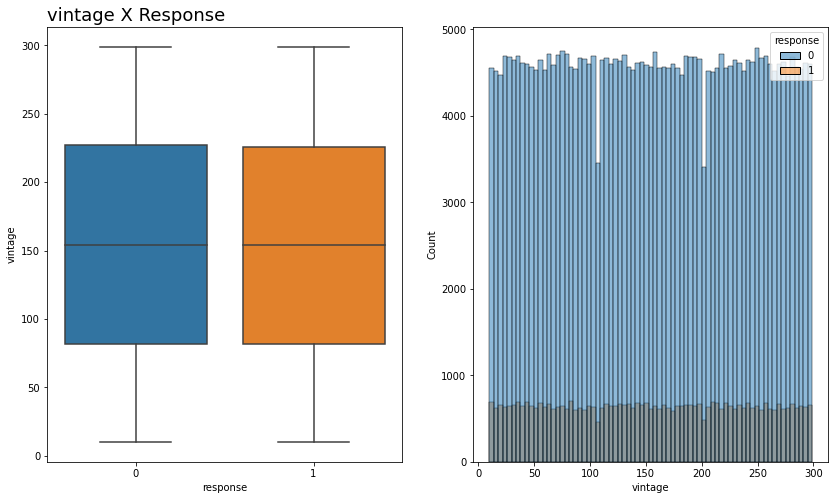

In [44]:
box_hist_plot('vintage')

<font size=4.5>The number of days don't seems to have an influence of response variable</font>

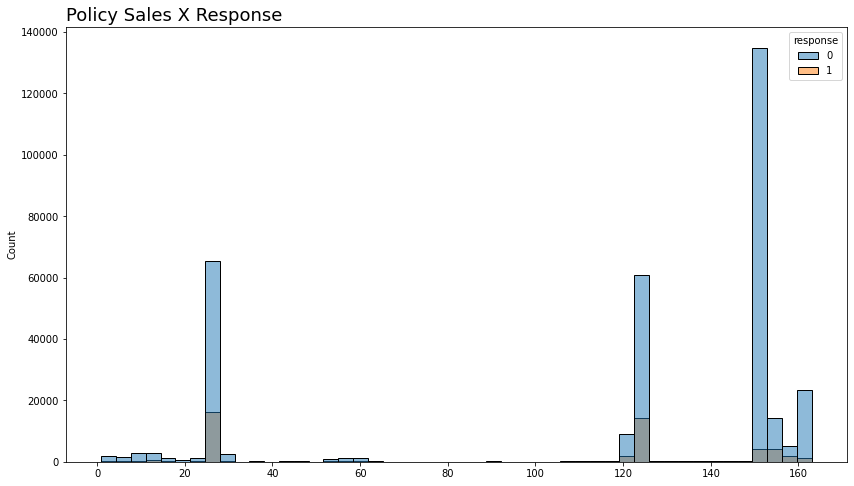

In [45]:
sns.histplot(data=df4, x='policy_sales_channel', hue='response')
graph_info('Policy Sales X Response')

<font size=4.5>Look like that next to 20 and 120 the posite response is higher</font>

### Binary Variables

In [46]:
pd.DataFrame(round(df4[['driving_license', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})

,driving_license,response,%
0,1,0,88.0
1,1,1,12.0
2,0,0,0.0
3,0,1,0.0


<font size=4.5>The driving license is not a good variable in decision tree models.</font>

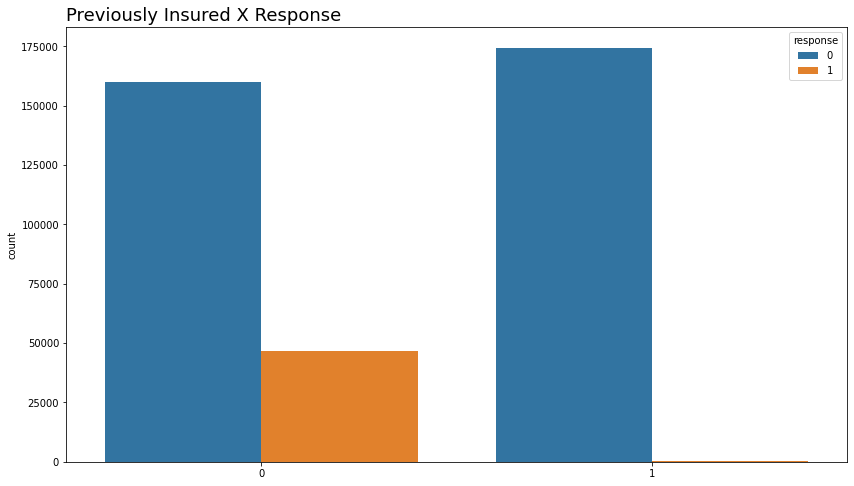

In [51]:
sns.countplot(data=df4, x='previously_insured', hue='response')
graph_info('Previously Insured X Response')

In [53]:
frequency_table(df4[['previously_insured', 'response']])

,previously_insured,response,%,Count
0,1,0,46.0,174470
1,0,0,42.0,159929
2,0,1,12.0,46552
3,1,1,0.0,158


## Multivariate Analysis

### Numerical

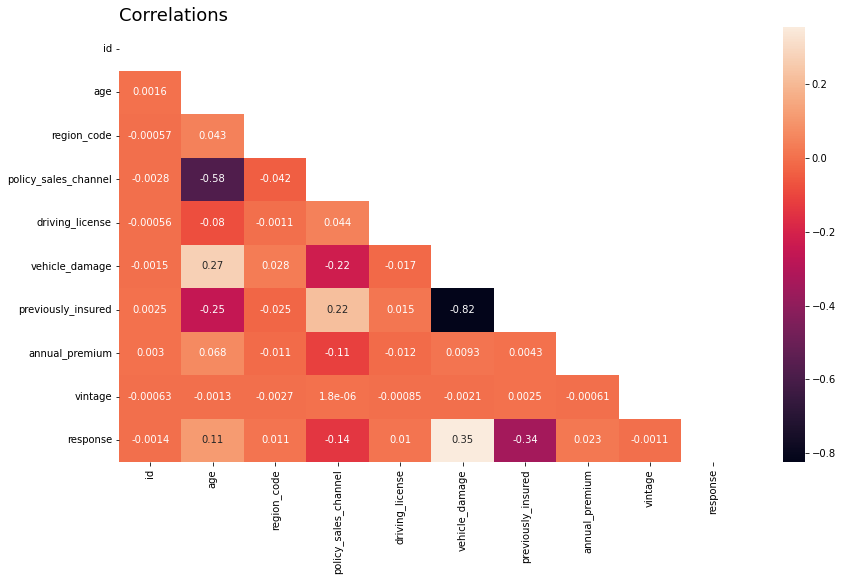

In [56]:
mask = np.zeros_like(df4.select_dtypes(['int64', 'float64']).corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df4.select_dtypes(['int64', 'float64']).corr(), annot=True, mask=mask)
graph_info('Correlations')

### Categorical

In [59]:
categoricals = df4[['gender', 'driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured', 
                    'response']]

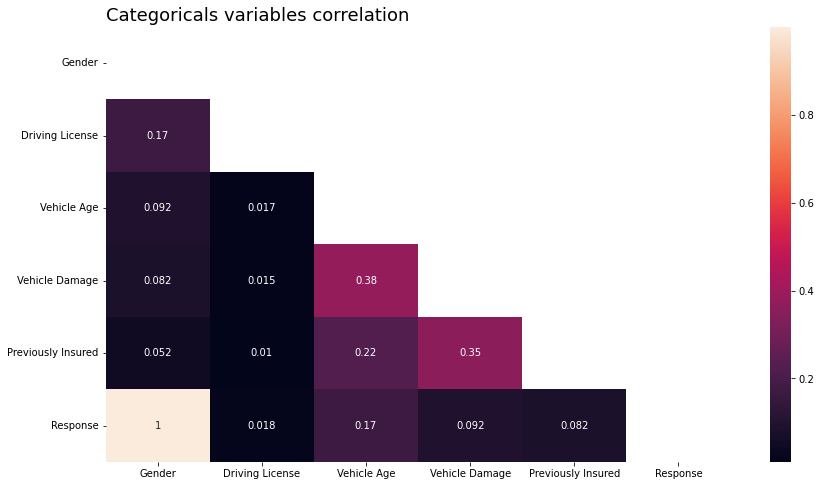

In [64]:
categoricals_1 = cramer_v(categoricals['gender'], categoricals['driving_license'])
categoricals_2 = cramer_v(categoricals['gender'], categoricals['vehicle_age'])
categoricals_3 = cramer_v(categoricals['gender'], categoricals['vehicle_damage'])
categoricals_4 = cramer_v(categoricals['gender'], categoricals['previously_insured'])
categoricals_5 = cramer_v(categoricals['gender'], categoricals['response'])
categoricals_6 = cramer_v(categoricals['gender'], categoricals['gender'])

categoricals_7 = cramer_v(categoricals['driving_license'], categoricals['driving_license'])
categoricals_8 = cramer_v(categoricals['driving_license'], categoricals['vehicle_age'])
categoricals_9 = cramer_v(categoricals['driving_license'], categoricals['vehicle_damage'])
categoricals_10 = cramer_v(categoricals['driving_license'], categoricals['previously_insured'])
categoricals_11 = cramer_v(categoricals['driving_license'], categoricals['response'])
categoricals_12 = cramer_v(categoricals['driving_license'], categoricals['gender'])

categoricals_13 = cramer_v(categoricals['vehicle_age'], categoricals['driving_license'])
categoricals_14 = cramer_v(categoricals['vehicle_age'], categoricals['vehicle_age'])
categoricals_15 = cramer_v(categoricals['vehicle_age'], categoricals['vehicle_damage'])
categoricals_16 = cramer_v(categoricals['vehicle_age'], categoricals['previously_insured'])
categoricals_17 = cramer_v(categoricals['vehicle_age'], categoricals['response'])
categoricals_18 = cramer_v(categoricals['vehicle_age'], categoricals['gender'])

categoricals_19 = cramer_v(categoricals['vehicle_damage'], categoricals['driving_license'])
categoricals_20 = cramer_v(categoricals['vehicle_damage'], categoricals['vehicle_age'])
categoricals_21 = cramer_v(categoricals['vehicle_damage'], categoricals['vehicle_damage'])
categoricals_22 = cramer_v(categoricals['vehicle_damage'], categoricals['previously_insured'])
categoricals_23 = cramer_v(categoricals['vehicle_damage'], categoricals['response'])
categoricals_24 = cramer_v(categoricals['vehicle_damage'], categoricals['gender'])

categoricals_25 = cramer_v(categoricals['previously_insured'], categoricals['driving_license'])
categoricals_26 = cramer_v(categoricals['previously_insured'], categoricals['vehicle_age'])
categoricals_27 = cramer_v(categoricals['previously_insured'], categoricals['vehicle_damage'])
categoricals_28 = cramer_v(categoricals['previously_insured'], categoricals['previously_insured'])
categoricals_29 = cramer_v(categoricals['previously_insured'], categoricals['response'])
categoricals_30 = cramer_v(categoricals['previously_insured'], categoricals['gender'])

categoricals_31 = cramer_v(categoricals['response'], categoricals['driving_license'])
categoricals_32 = cramer_v(categoricals['response'], categoricals['vehicle_age'])
categoricals_33 = cramer_v(categoricals['response'], categoricals['vehicle_damage'])
categoricals_34 = cramer_v(categoricals['response'], categoricals['previously_insured'])
categoricals_35 = cramer_v(categoricals['response'], categoricals['response'])
categoricals_36 = cramer_v(categoricals['response'], categoricals['gender'])


correlations = pd.DataFrame({
    'Gender': [categoricals_1, categoricals_2, categoricals_3, categoricals_4, categoricals_5, categoricals_6],
    'Driving License': [categoricals_7, categoricals_8, categoricals_9, categoricals_10, categoricals_11, 
                        categoricals_12],
    'Vehicle Age': [categoricals_13, categoricals_14, categoricals_15, categoricals_16, categoricals_17, 
                    categoricals_18],
    'Vehicle Damage': [categoricals_19, categoricals_20, categoricals_21, categoricals_22, categoricals_23, 
                       categoricals_24],
    'Previously Insured': [categoricals_25, categoricals_26, categoricals_27, categoricals_28, categoricals_29, 
                           categoricals_30],
    'Response': [categoricals_31, categoricals_32, categoricals_33, categoricals_34, categoricals_35, 
                 categoricals_36]
})
correlations = correlations.set_index(correlations.columns)

mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlations, annot=True, mask=mask)
graph_info('Categoricals variables correlation')

# Data Preparation

## Split Data

In [56]:
# Read file
df8 = pd.read_csv('../data/processed/df_feature_engineering.csv')

# Train (70%), Validation (20%) and Test (10%) data

# Test Data
df_test = df8.sample(frac=0.1, random_state=7).copy()

# Train and Validation
## Remove test data
df8 = df8.drop(df_test.index).copy()
## Split train and validation
X = df8.drop(columns='response').copy()
y = df8['response'].copy()
x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20)

## Encoder

    - One Hot Encoding
        Create new columns in the dataset
        
    - Frequency Encoding
        An frequency of a categorie related to response variable in dataset
        
    - Target Encoding
        An average of a categories in dataset
        
    - Weigthed Target Encoding
        Distance or approximation of the mean
    
    - Label Encoding
        No exist an order 
        
    - Order Encoding
        When exist an order in data

In [58]:
# Gender | Target Encoder | Can be done with categorical encoders library
target_gender = df8.groupby('gender')['response'].mean()
df8['gender'] = df8['gender'].map(target_gender)
x_train['gender'] = x_train['gender'].map(target_gender)
pickle.dump(target_gender, open('/home/marcos/Documents/pa004_health_insurance_cross_sell/cross_sell/src/features/target_gender.pkl', 'wb'))

# vehicle age
x_train = pd.get_dummies(x_train, columns=['vehicle_age'])

# policy_sales_channel
freq_policy_sales_channel = df8.groupby('policy_sales_channel').size() / len(df8)
x_train.loc[:, 'policy_sales_channel'] = x_train['policy_sales_channel'].map(freq_policy_sales_channel)
pickle.dump(freq_policy_sales_channel, open('/home/marcos/Documents/pa004_health_insurance_cross_sell/cross_sell/src/features/freq_policy_sales_channel.pkl', 'wb'))

# Region code
target_region_code = df8.groupby('region_code')['response'].mean()
x_train.loc[:, 'region_code'] = x_train['region_code'].map(target_region_code)
pickle.dump(target_region_code, open('/home/marcos/Documents/pa004_health_insurance_cross_sell/cross_sell/src/features/target_region_code.pkl', 'wb'))

## Standardization

In [59]:
# Anual premium
ss = StandardScaler()
x_train['annual_premium'] = ss.fit_transform(x_train[['annual_premium']].values)
pickle.dump(ss, open('/home/marcos/Documents/pa004_health_insurance_cross_sell/cross_sell/src/features/annual_premium_standard_scaler.pkl', 'wb'))

## Rescaling

In [60]:
# Age | MinMaxScale
mms = MinMaxScaler()
x_train['age'] = mms.fit_transform(x_train[['age']].values)
pickle.dump(mms, open('/home/marcos/Documents/pa004_health_insurance_cross_sell/cross_sell/src/features/age_min_max_scaler.pkl', 'wb'))

# Vintage
x_train['vintage'] = mms.fit_transform(x_train[['vintage']].values)
pickle.dump(mms, open('/home/marcos/Documents/pa004_health_insurance_cross_sell/cross_sell/src/features/vintage_min_max_scaler.pkl', 'wb'))

## Validation Preparation

In [61]:
# Gender | Target Encoder | Can be done with categorical encoders library
x_validation['gender'] = x_validation['gender'].map(target_gender)

# vehicle age
x_validation = pd.get_dummies(x_validation, columns=['vehicle_age'])

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(freq_policy_sales_channel)

# Region code
x_validation.loc[:, 'region_code'] = x_validation['region_code'].map(target_region_code)

# Anual premium
x_validation['annual_premium'] = ss.fit_transform(x_validation[['annual_premium']].values)

# Age | MinMaxScale
x_validation['age'] = mms.fit_transform(x_validation[['age']].values)

x_validation['vintage'] = mms.fit_transform(x_validation[['vintage']].values)

## Output File

In [65]:
# Train and Validation
x_validation.to_csv('../data/processed/x_validation.csv', index=False)
x_train.to_csv('../data/processed/x_train.csv', index=False) 

y_train.to_csv('../data/processed/y_train.csv', index=False) 
y_validation.to_csv('../data/processed/y_validation.csv', index=False)

# Test data
df_test.to_csv('../data/processed/df_test.csv', index=False)

# Feature Selection

In [22]:
#df9 = pd.read_csv('../data/processed/df_data_preparation.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()

x_train = pd.read_csv('../data/processed/x_train.csv')
x_validation = pd.read_csv('../data/processed/x_validation.csv')

## Feature Importance

In [23]:
# n_estimtors = The number of trees in the forest
# random_state = Set randomens control
# n_jobs = The number of jobs to run in parallel, -1 means using all processors.

# Remove id
x_train_n = x_train.drop(columns='id').copy()

forest = ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

forest.fit(x_train_n, y_train)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importances
0                annual_premium     0.271504
0            previously_insured     0.242970
0                        gender     0.165765
0                           age     0.106032
0               driving_license     0.067105
0                   region_code     0.060087
0                vehicle_damage     0.057700
0                       vintage     0.014443
0      vehicle_age_below_1_year     0.006426
0                            id     0.005258
0  vehicle_age_between_1_2_year     0.002234
0          policy_sales_channel     0.000476


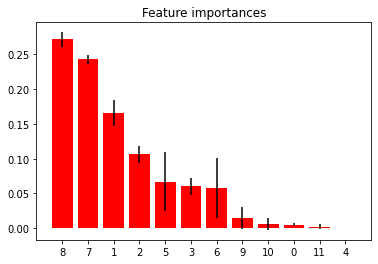

In [35]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importances': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importances', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

In [37]:
cols_selected = ['id', 'annual_premium', 'previously_insured', 'gender', 'age', 'driving_license', 'region_code', 'vehicle_damage']

## Output File

In [38]:
x_train[cols_selected].to_csv('../data/processed/x_train_feature_selection.csv', index=False)
x_validation[cols_selected].to_csv('../data/processed/x_validation_feature_selection.csv', index=False)

# Machine Learning

In [3]:
x_train = pd.read_csv('../data/processed/x_train_feature_selection.csv') 
x_validation = pd.read_csv('../data/processed/x_validation_feature_selection.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_validation = pd.read_csv('../data/processed/y_validation.csv')

In [4]:
# Remove user id
x_train_n = x_train.drop(columns='id', axis=1).copy()
x_validation_n = x_validation.drop(columns='id', axis=1).copy()

## KNN

In [41]:
# Model definition
knn = KNeighborsClassifier(n_neighbors=5)

# Train
knn.fit(x_train_n, y_train)

# Prediction
yhat_knn = knn.predict_proba(x_validation_n)

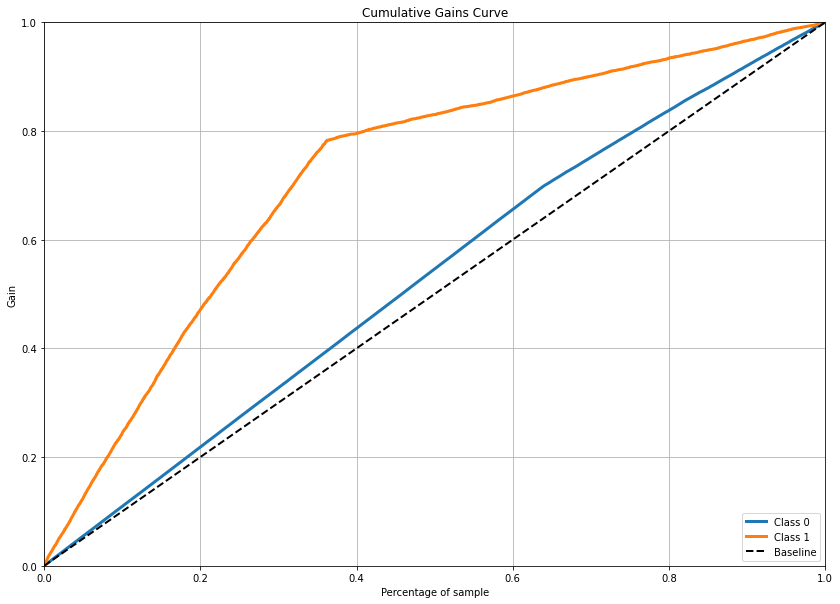

In [44]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_knn)
plt.show()

## Logistic Regression

In [5]:
# Model definition
lr = LogisticRegression(random_state=7)

# Train
lr.fit(x_train_n, y_train)

# Prediction
yhat_lr = lr.predict_proba(x_validation_n)

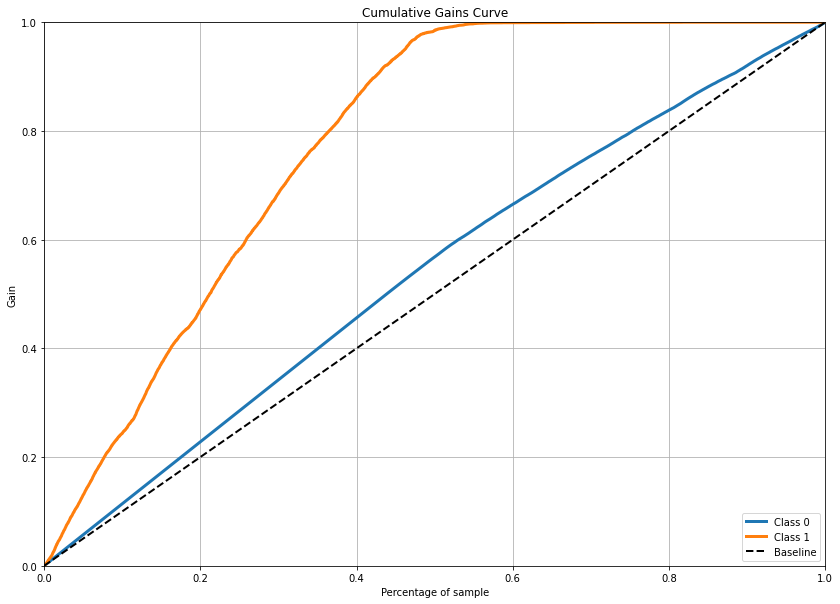

In [46]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lr)
plt.show()

## Extra Tree

In [9]:
# Model definition
et = ExtraTreesClassifier(n_estimators=100, random_state=7, n_jobs=-1)

# Train
et.fit(x_train_n, y_train)

# Prediction
yhat_et = et.predict_proba(x_validation_n)

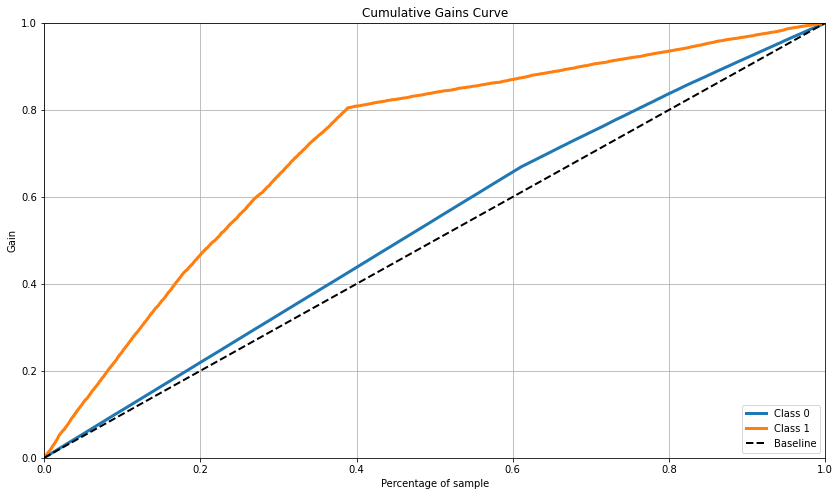

In [10]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_et)
plt.show()

# Model Performance

In [47]:
df11 = x_validation.copy()
df11['response'] = y_validation.copy()

In [48]:
# Create score column base on probabilites calculated to response equal to 1
df11['score'] = yhat_lr[:, 1].tolist()

In [49]:
df11 = df11.sort_values('score', ascending=False)

In [50]:
df11.head()

,id,annual_premium,previously_insured,gender,age,driving_license,region_code,vehicle_damage,response,score
38645,69969,-1.636433,0,0.138705,0.015385,1,0.189571,1,0,0.324751
39963,112640,-1.636433,0,0.138705,0.015385,1,0.189571,1,0,0.324751
16071,329509,-1.636433,0,0.138705,0.030769,1,0.189571,1,0,0.324475
64266,279958,-0.233019,0,0.138705,0.015385,1,0.189571,1,0,0.322365
3498,336878,-1.636433,0,0.138705,0.000000,1,0.186704,1,0,0.322016


In [53]:
recall_at_k(df11, model_name='Logistic Regression')

Model: Logistic Regression 
Ranking Position: 2000 
Recall: 0.08


In [54]:
precision_at_k(df11, model_name='Logistic Regression')

Model: Logistic Regression 
Ranking Position: 2000 
Precison: 0.32


# Business Performance

In [64]:
df12 = df11.copy()

<font size=4.5>**1. Main Insights on the most relevant attributes of customers interested in purchasing auto insurance.**</font>

    - Customers with new cars are more likely to take out insurance.
    - 58% of the positive response are between 33 and 52 years old
    - 76% of customers who had damaged cars responded positively.
    - Men represent the most positive responses.

<font size=4.5>**2. What percentage of customers interested in purchasing auto insurance will the sales team be able to contact by making 20,000 calls?**</font>

In [72]:
_ = round(df12['response'][:20_000].sum() / df12['response'].sum() * 100)
print(f'With 20.000 calls sales team will be contact {_}% of customers interested')

With 20.000 calls sales team will be contact 61% of customers interested


<font size=4.5>**3. If the sales team capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?**</font>

In [74]:
_ = round(df12['response'][:40_000].sum() / df12['response'].sum() * 100)
print(f'With 40.000 calls sales team will be contact {_}% of customers interested')

With 40.000 calls sales team will be contact 99% of customers interested


<font size=4.5>**4. How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?**</font>

In [80]:
_ = round(df12['response'][:27_500].sum() / df12['response'].sum() * 100)
print(f'With 27.500 calls sales team will be contact {_}% of customers interested')

With 27.500 calls sales team will be contact 80% of customers interested


# Deploy to Production

## Model

In [6]:
# Save trained model
pickle.dump(lr, open('/home/marcos/Documents/pa004_health_insurance_cross_sell/cross_sell/models/logistic_regression.pkl', 'wb'))

## Car Insurance Class

In [16]:
class AutoInsurance:
    '''
    --> Clean, transformate and training data to ranking customers
    '''
    def __init__(self, data): 
        '''
        --> Customers information to calculate probabilities
        '''      
        self._data                      = data
        self._path                      = '/home/marcos/Documents/pa004_health_insurance_cross_sell/cross_sell/src'
        self._target_gender             = pickle.load(open(self._path + '/features/target_gender.pkl', 'rb'))
        self._target_region_code        = pickle.load(open(self._path + '/features/target_region_code.pkl', 'rb'))
        self._age_scaler                = pickle.load(open(self._path + '/features/age_min_max_scaler.pkl', 'rb'))
        self._annual_premium_scaler     = pickle.load(open(self._path + '/features/annual_premium_standard_scaler.pkl', 'rb'))
        self._freq_policy_sales_channel = pickle.load(open(self._path + '/features/freq_policy_sales_channel.pkl', 'rb')) 
        self._vintage_scaler            = pickle.load(open(self._path + '/features/vintage_min_max_scaler.pkl', 'rb'))
        #self._logistic_regression       = pickle.load(open(self._path + '/models/logistic_regression.pkl', 'rb'))
        
      
    def data_clean(self):
        '''
        --> Change the format of data in vehicle age and vehicle damage columns
        '''
        self._data['vehicle_age'] = self._data['vehicle_age'].apply(lambda x: 'below_1_year' if x == '< 1 Year' 
                                                                    else 'between_1_2_year' if x == '1-2 Year' 
                                                                    else 'over_2_years')
        self._data['vehicle_damage'] = self._data['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        
        
    def data_preparation(self):
        '''
        --> Prepare data to modeling
        '''
        cols_selected = ['id', 'annual_premium', 'previously_insured', 'gender', 'age', 'driving_license', 
                         'region_code', 'vehicle_damage']
        # Gender | Target Encoder
        self._data['gender'] = self._data['gender'].map(self._target_gender)
        
        # vehicle age
        self._data = pd.get_dummies(self._data, columns=['vehicle_age'])
        
        # policy_sales_channel
        self._data.loc[:, 'policy_sales_channel'] = self._data['policy_sales_channel'].map(self._freq_policy_sales_channel)
        
        # Region code
        self._data.loc[:, 'region_code'] = self._data['region_code'].map(self._target_region_code)
        
        # Anual premium
        self._data['annual_premium'] = self._annual_premium_scaler.transform(self._data[['annual_premium']].values)
        
        # Age | MinMaxScale
        self._data['age'] = self._age_scaler.transform(self._data[['age']].values)
        
        # Vintage
        self._data['vintage'] = self._vintage_scaler.transform(self._data[['vintage']].values)
        
        
    def feature_selection(self):
        cols_selected = ['annual_premium', 'previously_insured', 'gender', 'age', 'driving_license', 
                         'region_code', 'vehicle_damage']
        self._data = self._data[cols_selected]
        

    def ranking_model(self, model, original_data):
        # Prediction
        yhat_lr = model.predict_proba(self._data)
        original_data['score'] = yhat_lr[:, 1].tolist()
        original_data.sort_values('score', ascending=False, inplace=True)
        return original_data(orient='records', date_format='iso')

## API Headler

In [17]:
# Load model
path = '/home/marcos/Documents/pa004_health_insurance_cross_sell/cross_sell/src'
model = pickle.load(open(path + '/models/logistic_regression.pkl', 'rb'))

# Initialize API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # There is data
        if isinstance(test_json, dict): # Unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # Multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Health Insurance Class
        pipeline = AutothInsurance(test_raw)
        pipeline.data_clean()
        pipeline.data_preparation()
        pipeline.feature_selection()
        df_response = pipeline.ranking_model(model=model, original_data=test_raw)
        return df_response
    else:
        return Response('{}', status=200, mimetype='application/json')
if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on all addresses.
 * Running on http://192.168.0.61:5000/ (Press CTRL+C to quit)
 * Restarting with stat
Traceback (most recent call last):
  File "/home/marcos/Documents/pa004_health_insurance_cross_sell/env_pa004/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/marcos/Documents/pa004_health_insurance_cross_sell/env_pa004/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.initialize(argv)
  File "/home/marcos/Documents/pa004_health_insurance_cross_sell/env_pa004/lib/python3.8/site-packages/traitlets/config/application.py", line 88, in inner
    return method(app, *args, **kwargs)
  File "/home/marcos/Documents/pa004_health_insurance_cross_sell/env_pa004/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 632, in initialize
    self.init_sockets()
  File "/home/marcos/Documents/pa004_health_insurance_cross_sell/env_pa004/lib/python3.8/site-packages/ipyker

SystemExit: 1

## API Tester

In [2]:
# Read file
df8 = pd.read_csv('../data/processed/df_feature_engineering.csv')

# Split explanatory and response
X = df8.drop(columns='response').copy()
y = df8['response'].copy()
x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20)


df_test = x_validation.copy()
df_test['response'] = y_validation.copy()

In [3]:
df_test_sample = df_test.sample(2)

In [4]:
data = json.dumps(df_test_sample.to_dict(orient='records'))

In [15]:
data

'[{"id": 155230, "gender": "Male", "age": 39, "region_code": 28.0, "policy_sales_channel": 124.0, "driving_license": 1, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "previously_insured": 0, "annual_premium": 35048.0, "vintage": 125, "response": 0}, {"id": 350396, "gender": "Male", "age": 28, "region_code": 8.0, "policy_sales_channel": 152.0, "driving_license": 1, "vehicle_age": "below_1_year", "vehicle_damage": 0, "previously_insured": 1, "annual_premium": 46230.0, "vintage": 94, "response": 0}]'

In [5]:
# API Call
url = 'http://0.0.0.0:5000/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data, headers=header)
print(f'Status Code {r.status_code}')

Status Code 200


In [7]:
result = pd.DataFrame(r.json(), columns=r.json()[0].keys())
result

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,score
0,51458,0.138461,26,36.0,152.0,1,over_2_years,0,1,30406.0,142,0,8.612726e-114
1,14207,0.103849,69,28.0,147.0,1,over_2_years,0,0,66893.0,41,0,1.296308e-243
